In [ ]:
import warnings
from typing import List, Optional, Tuple, Union

import joblib
import matplotlib.pyplot as plt
import mne
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from mne.filter import filter_data
from scipy.signal import butter, filtfilt, medfilt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from bci_aic3.config import (
    ProcessingConfig,
    load_model_config,
    load_processing_config,
    load_training_config,
)
from bci_aic3.data import load_raw_data
from bci_aic3.paths import (
    LABEL_MAPPING_PATH,
    MI_CONFIG_PATH,
    PROCESSED_DATA_DIR,
    RAW_DATA_DIR,
    SSVEP_CONFIG_PATH,
    TRAINING_STATS_PATH,
)
from bci_aic3.util import read_json_to_dict

label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)

sns.set_theme()
%matplotlib inline

In [2]:
train, val, test = load_raw_data(
    base_path=RAW_DATA_DIR, task_type="MI", label_mapping=label_mapping
)

  0%|          | 0/2400 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 19.73it/s]


In [ ]:
from scipy.interpolate import interp1d
from scipy.signal import decimate
from sklearn.preprocessing import RobustScaler


class MNENotchFilter(BaseEstimator, TransformerMixin):
    """Notch filter using MNE for EEG data."""

    def __init__(self, sfreq: float = 250.0, notch_freq: Union[float, list] = 50.0):
        self.sfreq = sfreq
        self.notch_freq = notch_freq

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply notch filter to EEG data.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Filtered EEG data of same shape
        """
        X_filtered = np.zeros_like(X)

        for i, epoch in enumerate(X):
            filtered = mne.filter.notch_filter(
                epoch.astype(float),
                Fs=self.sfreq,
                freqs=self.notch_freq,
                method="fir",
                verbose=False,
            )
            X_filtered[i] = filtered

        return X_filtered


class BandPassFilter(BaseEstimator, TransformerMixin):
    """Butterworth bandpass filter for EEG signals."""

    def __init__(
        self,
        sfreq: float = 250.0,
        low_freq: float = 1.0,
        high_freq: float = 40.0,
        order: int = 4,
    ):
        self.sfreq = sfreq
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.order = order
        self._filter_coeffs = None

    def fit(self, X, y=None):
        # Pre-compute filter coefficients
        nyquist = self.sfreq / 2
        low = self.low_freq / nyquist
        high = self.high_freq / nyquist
        self._filter_coeffs = butter(self.order, [low, high], btype="bandpass")
        return self

    def transform(self, X):
        """Apply bandpass filter to EEG data.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Filtered EEG data of same shape
        """
        if self._filter_coeffs is None:
            raise ValueError("Filter not fitted. Call fit() first.")

        b, a = self._filter_coeffs  # type: ignore
        X_filtered = np.zeros_like(X)

        for i, epoch in enumerate(X):
            filtered = np.array([filtfilt(b, a, ch) for ch in epoch])
            X_filtered[i] = filtered

        return X_filtered


class MedianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X shape: (n_trials, n_channels, n_timepoints)
        filtered = np.zeros_like(X)
        for trial in range(X.shape[0]):
            for channel in range(X.shape[1]):
                filtered[trial, channel] = medfilt(X[trial, channel], self.kernel_size)
        return filtered


class Downsample(BaseEstimator, TransformerMixin):
    """
    Downsample time series data from (n_trials, n_channels, n_timepoints)
    to a lower sampling rate.

    Parameters
    ----------
    factor : int
        Downsampling factor (keep every factor-th sample)
    """

    def __init__(self, factor):
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Downsample along the last axis (timepoints)"""
        return decimate(X, self.factor, axis=-1, ftype="fir")


class TemporalCrop(BaseEstimator, TransformerMixin):
    """Crop EEG signal in time dimension."""

    def __init__(self, tmin: float = 0.0, tmax: float = 4.0, sfreq: float = 250.0):
        self.tmin = tmin
        self.tmax = tmax
        self.sfreq = sfreq
        self._start_idx = None
        self._end_idx = None

    def fit(self, X, y=None):
        self._start_idx = int(self.tmin * self.sfreq)
        self._end_idx = int(self.tmax * self.sfreq)
        return self

    def transform(self, X):
        """Crop EEG data in time.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Cropped EEG data of shape (n_samples, n_channels, cropped_timepoints)
        """
        return X[:, :, self._start_idx : self._end_idx]


class BaselineCorrection(BaseEstimator, TransformerMixin):
    """Trial-mean baseline correction for EEG data."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply trial-mean baseline correction.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Baseline corrected EEG data of same shape
        """
        trial_mean = np.mean(X, axis=2, keepdims=True)
        return X - trial_mean


class MNEICA(BaseEstimator, TransformerMixin):
    """
    Scikit-learn compatible transformer for non-destructive EEG artifact removal using MNE's ICA.

    This transformer fits ICA on the provided data, allows for the exclusion of artifactual
    components, and then reconstructs the signal without these components.

    Parameters
    ----------
    sfreq : float
        The sampling frequency of the EEG data.
    n_components : int | float | None, default=None
        The number of principal components to use for ICA.
    montage : str, default=None
        The name of the standard MNE montage to apply for sensor locations (e.g., 'standard_1020').
        This is required for plotting component topographies.
    random_state : int | None, default=None
        The seed for the random number generator for reproducibility.
    exclude : list of int, default=None
        A list of IC indices to exclude.
    """

    def __init__(
        self,
        sfreq: float,
        ch_names: List[str],
        n_components: Union[int, float, None] = None,
        montage: str = "standard_1020",
        random_state: int = 42,
        exclude: list = None,
    ):
        self.sfreq = sfreq
        self.n_components = n_components
        self.montage = montage  # New parameter
        self.random_state = random_state
        self.exclude = exclude
        self.ch_names = ch_names  # Will store the channel names
        self.ica_ = None
        self.info_ = None  # Will store the info with the montage

    def fit(self, X, y=None):
        """
        Fits the ICA model to the EEG data.

        Args:
            X: EEG data of shape (n_epochs, n_channels, n_timepoints)
            y: Not used, for compatibility with sklearn API.
            ch_names: A list of channel names. Required if a montage is set for plotting.
        """
        n_epochs, n_channels, _ = X.shape

        X_concat = np.concatenate(X, axis=1)

        self.info_ = mne.create_info(
            ch_names=self.ch_names, sfreq=self.sfreq, ch_types="eeg"
        )
        raw = mne.io.RawArray(X_concat, self.info_, verbose=False)

        # --- Set the Montage ---
        if self.montage:
            try:
                montage_obj = mne.channels.make_standard_montage(self.montage)
                raw.set_montage(montage_obj, on_missing="warn", verbose=False)
                # Store the updated info object
                self.info_ = raw.info
            except ValueError as e:
                print(
                    f"Error setting montage: {e}. Please ensure your channel names "
                    f"(e.g., 'Fp1', 'Cz') match the names in the '{self.montage}' montage."
                )
                # Continue without montage for processing, but plotting will fail
                pass

        raw.filter(l_freq=1.0, h_freq=None, verbose=False)

        self.ica_ = mne.preprocessing.ICA(
            n_components=self.n_components,
            random_state=self.random_state,
        )
        self.ica_.fit(raw, verbose=False)

        return self

    def transform(self, X):
        # ... (This method remains unchanged)
        if self.ica_ is None:
            raise RuntimeError(
                "The ICA model has not been fitted yet. Call fit() first."
            )

        if self.exclude is None:
            print(
                "Warning: The 'exclude' attribute is not set. No components will be removed."
            )
            return X

        X_transformed = np.zeros_like(X)
        # Use the stored info object to ensure consistency
        info = mne.create_info(ch_names=self.ch_names, sfreq=self.sfreq, ch_types="eeg")

        for i, epoch in enumerate(X):
            raw_epoch = mne.io.RawArray(epoch, info, verbose=False)
            self.ica_.apply(raw_epoch, exclude=self.exclude, verbose=False)
            X_transformed[i] = raw_epoch.get_data()

        return X_transformed

    def plot_components(self, **kwargs):
        """
        Plot the ICA components. Now uses the stored info with montage.
        """
        if self.ica_ is None:
            raise RuntimeError(
                "The ICA model has not been fitted yet. Call fit() first."
            )
        if self.info_.get_montage() is None:  # type: ignore
            raise RuntimeError(
                "Cannot plot components because no valid montage is set. "
                "Please provide a montage during initialization and ensure "
                "channel names are correct."
            )

        # Pass the info object with sensor locations to the plot function
        return self.ica_.plot_components(**kwargs)

    def plot_sources(self, X, **kwargs):
        """
        Plot the time course of the ICA sources.
        """
        if self.ica_ is None:
            raise RuntimeError(
                "The ICA model has not been fitted yet. Call fit() first."
            )

        X_concat = np.concatenate(X, axis=1)
        raw = mne.io.RawArray(X_concat, self.info_, verbose=False)
        return self.ica_.plot_sources(raw, **kwargs)


class ChannelWiseNormalizer(BaseEstimator, TransformerMixin):
    """Channel-wise normalization (z-score) for EEG data."""

    def __init__(self, axis: Tuple[int, ...] = (0, 2)):
        """
        Args:
            axis: Axes over which to compute mean and std for normalization.
                  Default (0, 2) normalizes across samples and time for each channel.
        """
        self.axis = axis
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        """Compute channel-wise statistics from training data.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)
        """
        self.mean_ = np.mean(X, axis=self.axis, keepdims=True)
        self.std_ = np.std(X, axis=self.axis, keepdims=True)

        # Avoid division by zero
        self.std_[self.std_ == 0] = 1e-6

        return self

    def transform(self, X):
        """Apply channel-wise normalization.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Normalized EEG data of same shape
        """
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Normalizer not fitted. Call fit() first.")

        return (X - self.mean_) / self.std_


class DumbScaler(BaseEstimator, TransformerMixin):
    """Flatten all trials and apply StandardScalar then reshape it back."""

    def __init__(self, scaler_type: str = "robust"):
        """
        Args:
            scaler: "robust" or "standard"
        """
        self.scaler_type = scaler_type
        if self.scaler_type == "robust":
            self.scaler_ = RobustScaler()
        elif self.scaler_type == "standard":
            self.scaler_ = StandardScaler()

    def fit(self, X, y=None):
        X_flattened = X.flatten().reshape((-1, 1))
        self.scaler_.fit(X_flattened)
        return self

    def transform(self, X):
        n_trials, n_channels, n_timepoints = X.shape
        X_flattened = X.flatten().reshape((-1, 1))
        X_normalized = self.scaler_.transform(X_flattened)
        return X_normalized.reshape(n_trials, n_channels, n_timepoints)


class SpikeRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_factor=3.0):
        self.threshold_factor = threshold_factor

    def fit(self, X, y=None):
        # Calculate global threshold from training data
        self.threshold = self.threshold_factor * np.std(X)
        return self

    def transform(self, X):
        # X shape: (n_trials, n_channels, n_timepoints)
        filtered = X.copy()

        for trial in range(X.shape[0]):
            # Find spikes that occur across all channels simultaneously
            spike_mask = np.all(np.abs(X[trial]) > self.threshold, axis=0)

            if np.any(spike_mask):
                # Find spike regions
                spike_indices = np.where(spike_mask)[0]

                for channel in range(X.shape[1]):
                    signal = X[trial, channel]

                    # Interpolate over spike regions
                    good_indices = ~spike_mask
                    if np.sum(good_indices) > 1:
                        f = interp1d(
                            np.where(good_indices)[0],
                            signal[good_indices],
                            kind="linear",
                            fill_value="extrapolate",
                        )
                        filtered[trial, channel, spike_indices] = f(spike_indices)

        return filtered


class EEGReshaper(BaseEstimator, TransformerMixin):
    """Reshape EEG data for different model requirements."""

    def __init__(self, target_shape: str = "flatten"):
        """
        Args:
            target_shape: 'flatten' to reshape to (n_samples, n_features)
                         'keep' to maintain original shape
        """
        self.target_shape = target_shape
        self.original_shape_ = None

    def fit(self, X, y=None):
        self.original_shape_ = X.shape[1:]  # Store shape without sample dimension
        return self

    def transform(self, X):
        """Reshape EEG data."""
        if self.target_shape == "flatten":
            return X.reshape(X.shape[0], -1)
        return X

    def inverse_transform(self, X):
        """Restore original shape."""
        if self.target_shape == "flatten" and self.original_shape_ is not None:
            return X.reshape(X.shape[0], *self.original_shape_)
        return X


def unsqueeze_for_eeg(X):
    """
    Unsqueezes the input data to add a new dimension for the channel axis.
    """
    return np.expand_dims(X, axis=1)


In [ ]:
def create_eeg_pipeline(
    task_type: str,
    processing_config: ProcessingConfig,
    ica_exclude: List[int],
    full: bool = True,
):
    """
    Create a scikit-learn pipeline for EEG preprocessing.

    Args:
        task_type: 'MI' or 'SSVEP'
        processing_config: Configuration object with processing parameters
        test: when set to true artifact removal transform is excluded

    Returns:
        sklearn.pipeline.Pipeline
    """

    # Define pipeline steps
    steps = [
        (
            "notch_filter",
            MNENotchFilter(
                sfreq=processing_config.sfreq, notch_freq=processing_config.notch_freq
            ),
        ),
        (
            "bandpass_filter",
            BandPassFilter(
                sfreq=processing_config.sfreq,
                low_freq=processing_config.bandpass_low,
                high_freq=processing_config.bandpass_high,
                order=processing_config.filter_order,
            ),
        ),
        # ("downsample", Downsample(factor=2)),
        # ("medfilt", MedianFilter(kernel_size=13)),
        ("spike_remover", SpikeRemover(threshold_factor=2)),
        (
            "temporal_crop",
            TemporalCrop(
                tmin=processing_config.tmin,
                tmax=processing_config.tmax,
                sfreq=processing_config.sfreq / 2,
            ),
        ),
        (
            "ica",
            MNEICA(
                sfreq=processing_config.sfreq,
                n_components=processing_config.ica_components,
                ch_names=processing_config.ch_names,
                random_state=42,
                exclude=ica_exclude,
            ),
        ),
        # ("channel_wise", ChannelWiseNormalizer()),
        # ("unsqueeze", FunctionTransformer(unsqueeze_for_eeg)),
    ]
    if full:
        # ("dumb_scaler", DumbScaler(scaler_type="robust")),
        steps.extend(
            [
                ("channel_wise", ChannelWiseNormalizer()),
                ("unsqueeze", FunctionTransformer(unsqueeze_for_eeg)),
            ]
        )

    return Pipeline(steps)

In [95]:
train_loader = DataLoader(
    train,
    batch_size=len(train),  # type: ignore
    shuffle=False,
)
train_data, train_labels = next(iter(train_loader))
train_data, train_labels = train_data.numpy(), train_labels.numpy()

val_loader = DataLoader(
    val,
    batch_size=len(val),  # type: ignore
    shuffle=False,
)
val_data, val_labels = next(iter(val_loader))
val_data, val_labels = val_data.numpy(), val_labels.numpy()

In [96]:
processing_config = load_processing_config(MI_CONFIG_PATH)

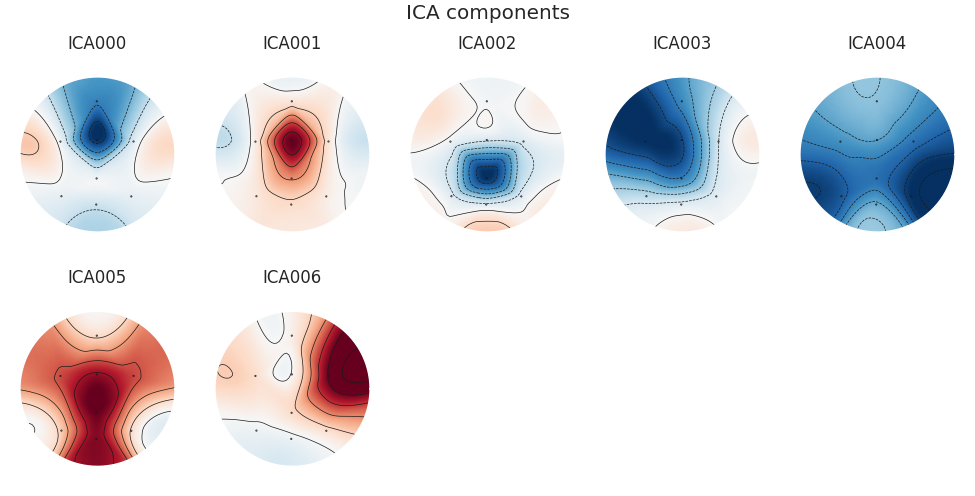

In [97]:
pipeline = create_eeg_pipeline(
    task_type="MI",
    processing_config=processing_config,
    ica_exclude=None,
    full=False,
)
pipeline.fit(train_data)
pipeline.named_steps["ica"].plot_components()
print()

In [98]:
%matplotlib widget

Creating RawArray with float64 data, n_channels=7, n_times=1951200
    Range : 0 ... 1951199 =      0.000 ...  7804.796 secs
Ready.


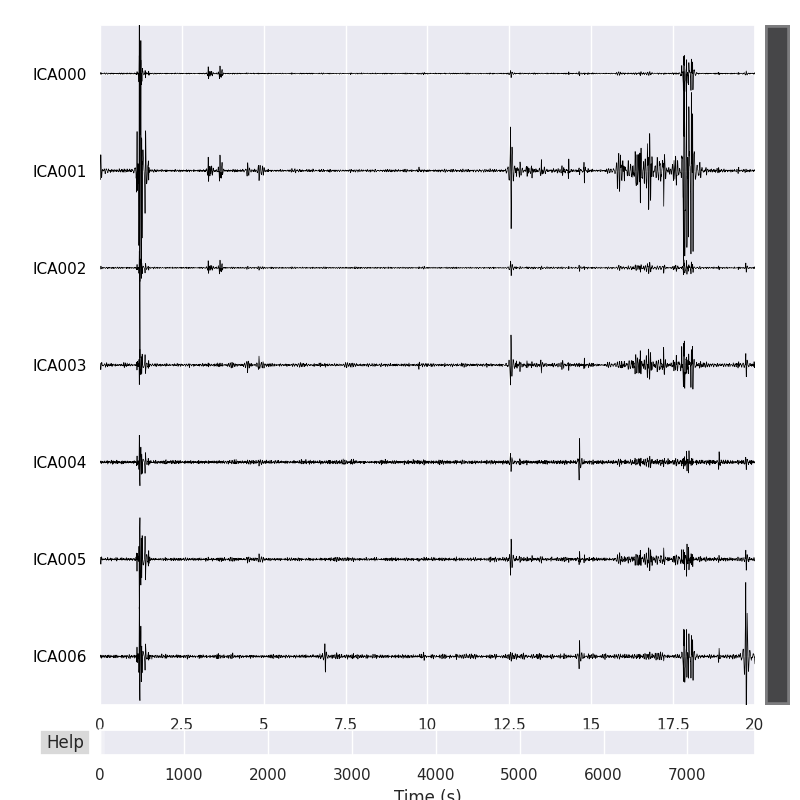

In [99]:
transformed_data = pipeline.transform(train_data)
pipeline.named_steps["ica"].plot_sources(transformed_data)
print()

In [100]:
def preprocess_and_save(
    train_dataset: Dataset,
    val_dataset: Dataset,
    task_type: str,
    processing_config: ProcessingConfig,
):
    train_loader = DataLoader(
        train_dataset,
        batch_size=len(train_dataset),  # type: ignore
        shuffle=False,
    )
    train_data, train_labels = next(iter(train_loader))
    train_data, train_labels = train_data.numpy(), train_labels.numpy()

    val_loader = DataLoader(
        val_dataset,
        batch_size=len(val_dataset),  # type: ignore
        shuffle=False,
    )
    val_data, val_labels = next(iter(val_loader))
    val_data, val_labels = val_data.numpy(), val_labels.numpy()

    train_pipeline = create_eeg_pipeline(
        task_type=task_type,
        processing_config=processing_config,
        ica_exclude=processing_config.ica_exclude,
        full=True,
    )
    print("\nTraining Pipeline steps:")
    for i, (name, transformer) in enumerate(train_pipeline.steps):
        print(f"{i + 1}. {name}: {transformer}")

    print(f"\nOriginal train data shape: {train_data.shape}")
    print(f"Original validation data shape: {val_data.shape}")

    train_data_transformed = train_pipeline.fit_transform(train_data)
    train_labels_transformed = train_labels
    print(f"\nTransformed train data shape: {train_data_transformed.shape}")
    print(f"Transformed train labels shape: {train_labels_transformed.shape}")

    val_data_transformed = train_pipeline.transform(val_data)
    val_labels_transformed = val_labels
    print(f"\nTransformed validation data shape: {val_data_transformed.shape}")
    print(f"Transformed validation labels shape: {val_labels_transformed.shape}")

    print(
        "\nTrain Channel Means (should be zero mean):\n",
        train_data_transformed.mean(axis=(0, 1, 3)),
    )
    print(
        "\nTrain Channel Standard Deviations (should be unit std):\n",
        train_data_transformed.std(axis=(0, 1, 3)),
    )
    print(
        "\nValidation Channel Means (should be zero mean):\n",
        val_data_transformed.mean(axis=(0, 1, 3)),
    )
    print(
        "\nValidation Channel Standard Deviations (should be unit std or close to it):\n",
        val_data_transformed.std(axis=(0, 1, 3)),
    )

    output_dir = PROCESSED_DATA_DIR / task_type.upper()
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / "train_data.npy", train_data_transformed)
    np.save(output_dir / "train_labels.npy", train_labels_transformed)
    np.save(output_dir / "validation_data.npy", val_data_transformed)
    np.save(output_dir / "validation_labels.npy", val_labels_transformed)
    print(f"\n✅ Processed data successfully saved to '{output_dir}'")

    pipeline_dir = TRAINING_STATS_PATH / task_type.upper()
    pipeline_dir.mkdir(parents=True, exist_ok=True)
    joblib.dump(train_pipeline, pipeline_dir / "transform_pipeline.pkl")
    print(f"\n✅ Preprocessing pipelines successfully saved to '{pipeline_dir}'")


In [ ]:
processing_config = load_processing_config(MI_CONFIG_PATH)
preprocess_and_save(train, val, task_type="MI", processing_config=processing_config)


Training Pipeline steps:
1. notch_filter: MNENotchFilter()
2. bandpass_filter: BandPassFilter(high_freq=32.0, low_freq=6.0, order=5)
3. downsample: Downsample(factor=2)
4. spike_remover: SpikeRemover(threshold_factor=3)
5. temporal_crop: TemporalCrop(sfreq=125.0, tmax=7, tmin=0.5)
6. ica: MNEICA(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'],
       exclude=[0, 1, 2, 6, 7], n_components=7, sfreq=250.0)
7. channel_wise: ChannelWiseNormalizer()
8. unsqueeze: FunctionTransformer(func=<function unsqueeze_for_eeg at 0x7fc9b90d4a40>)

Original train data shape: (2400, 8, 2250)
Original validation data shape: (50, 8, 2250)

Transformed train data shape: (2400, 1, 8, 813)
Transformed train labels shape: (2400,)

Transformed validation data shape: (50, 1, 8, 813)
Transformed validation labels shape: (50,)

Train Channel Means (should be zero mean):
 [ 4.5454956e-10 -1.2874016e-09 -3.8514522e-10  1.1050931e-09
 -1.5811483e-10  3.3626893e-10  4.3444920e-10 -5.6189414e-10]

Train Cha

: 